# FX vol trading strategy - implementation

In [49]:
# Import libraries
import pandas as pd
import numpy as np
from data_cleaning.import_data import import_data
from utils.garch import get_rolling_vol_forecasts
from utils.plots import plot_trades, plot_grid_forecasted_vs_realized
from utils.trading_strategy import gen_trading_signals, forecasting_accuracy
from arch import arch_model

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
fx_pairs =[
    'USDRUB',
    'USDZAR',
    'USDBRL',
    'EURUSD',
    'USDJPY',
    'GBPUSD'
]
dfs = { pair : import_data(fx_pair=pair) for pair in fx_pairs }

## Pick FX pair and set up model

In [51]:
pair = 'USDRUB'

<AxesSubplot:xlabel='Dates'>

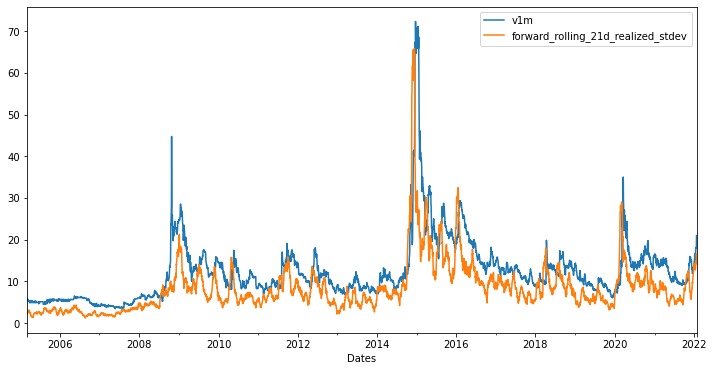

In [53]:
dfs[pair][['v1m','forward_rolling_21d_realized_stdev']].dropna().plot(figsize=(12,6))

## Forecast volatility

In [54]:
return_series = dfs[pair].dropna()['log_ret'] * 100
model = arch_model(return_series, mean='AR', vol='GARCH', p=1, q=1, dist='Studentst')

# Conditional volatility forecasting
vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                            model = model, 
                                            horizon=21,
                                            fitting_end_date="2021-01-01",
                                            )
df = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
df.rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
df['cond_forecast_to_implied'] = df['cond_vol_forecast'] / df['v1m']
df

Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................

,v1m,v3m,v1y,px_last,px_bid,px_ask,log_ret,rolling_21d_realized_stdev,forward_rolling_21d_realized_stdev,normalized_bid_ask_spread,cond_vol_forecast,cond_forecast_to_implied
2021-01-01,16.3650,15.6350,14.565,74.4128,74.4000,74.4255,0.000000,10.758151,8.078103,0.034268,11.816320,0.722048
2021-01-04,16.3600,15.5050,14.400,74.3254,74.3127,74.3381,-0.001175,10.448617,8.072906,0.034174,11.035378,0.674534
2021-01-05,16.5800,15.5850,14.525,74.0237,74.0115,74.0359,-0.004067,10.331997,8.055850,0.032962,10.470244,0.631498
2021-01-06,16.0800,15.3950,14.435,73.9273,73.9202,73.9343,-0.001303,10.306710,8.389308,0.019073,9.780308,0.608228
2021-01-07,16.1150,15.4425,14.465,73.9273,73.9202,73.9343,0.000000,9.941866,9.249474,0.019073,9.117689,0.565789
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-18,18.0150,17.5500,17.100,76.9664,76.9420,76.9909,0.011275,10.346831,14.159713,0.063534,12.841634,0.712830
2022-01-19,17.9125,17.5900,17.150,76.2094,76.1947,76.2240,-0.009884,10.921787,14.457883,0.038447,13.046455,0.728344
2022-01-20,18.1275,17.5700,17.085,76.6905,76.6810,76.7000,0.006293,11.154320,14.984820,0.024775,12.619772,0.696167
2022-01-21,18.7300,18.0550,17.340,77.4677,77.4467,77.4886,0.010083,11.446391,16.548842,0.054087,12.954912,0.691666


<AxesSubplot:>

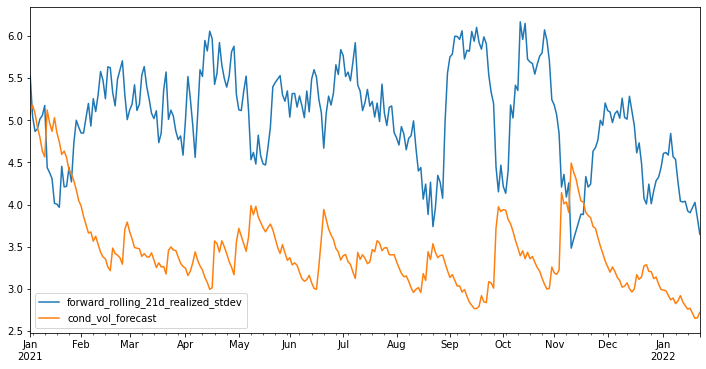

In [26]:
df[['forward_rolling_21d_realized_stdev','cond_vol_forecast']].plot(figsize=(12,6))

<AxesSubplot:>

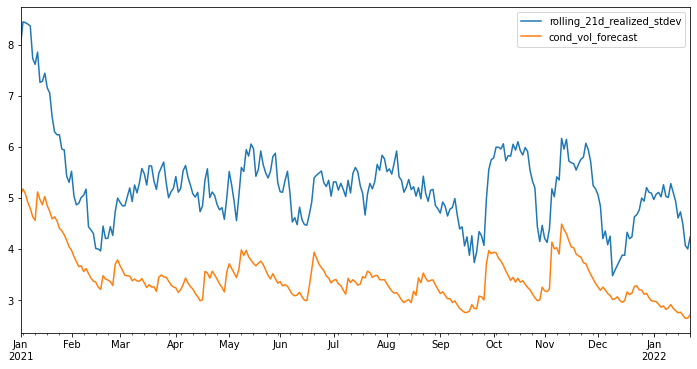

In [27]:
df[['rolling_21d_realized_stdev','cond_vol_forecast']].plot(figsize=(12,6))

In [57]:
for pair, df in dfs.items():
    return_series = dfs[pair].dropna()['log_ret'] * 100
    model = arch_model(return_series, mean='AR', vol='GARCH', p=1, q=1, dist='Studentst')

    # Conditional volatility forecasting
    vol_forecasts = get_rolling_vol_forecasts(return_series=return_series,
                                                model = model, 
                                                horizon=21,
                                                fitting_end_date="2021-01-01",
                                                )
    dfs[pair] = dfs[pair].merge(vol_forecasts['h.21'], left_index=True, right_index=True)
    dfs[pair].rename(columns={'h.21':'cond_vol_forecast'},inplace=True)
    dfs[pair]['cond_forecast_to_implied'] = dfs[pair]['cond_vol_forecast'] / dfs[pair]['v1m']


Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.....................................................................................................................................................................................................................................................................................Fitting rolling GARCH(p: 1, q: 1) model with a Standardized Student's t distribution.
Number of forecasts: 277
.................................................................................................................

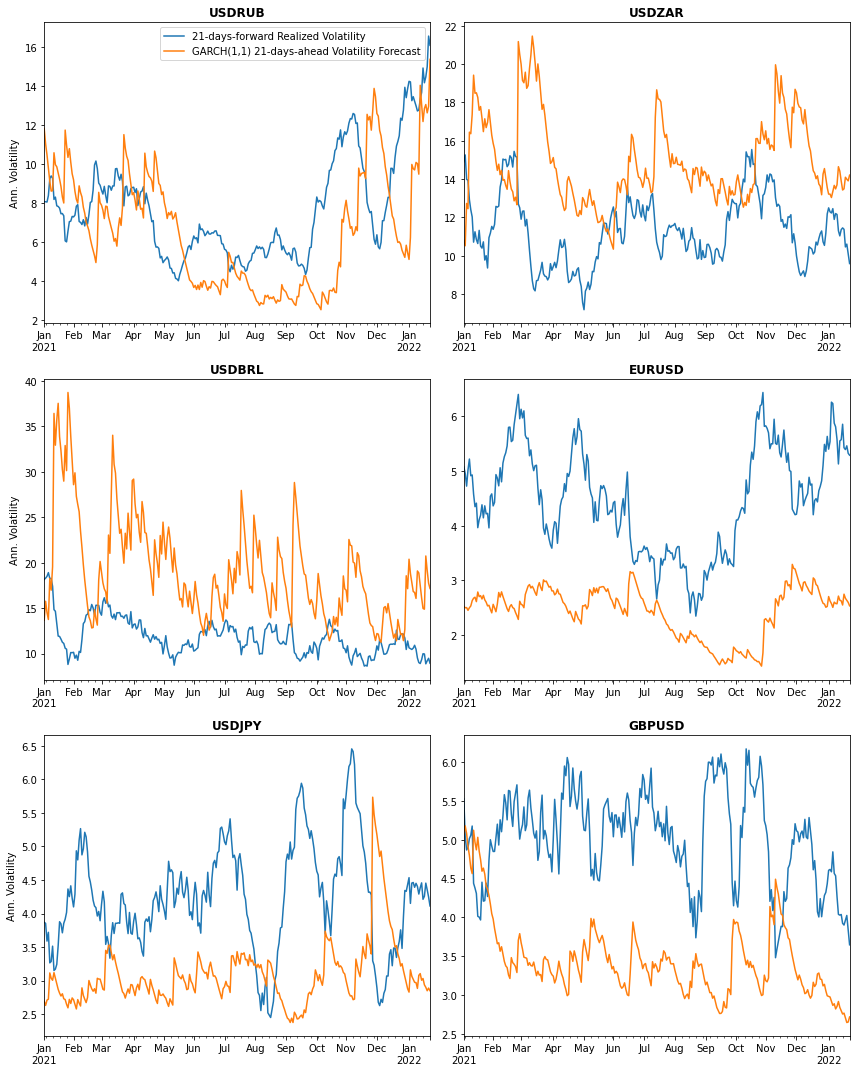

In [42]:
plot_grid_forecasted_vs_realized(df_dict=dfs, implied=False)

## Out-of-sample forecasting accuracy

https://stats.stackexchange.com/questions/205562/evaluate-forecasting-ability-of-garch-models-with-rmse-and-mae

Although Dunis et al. use RMSE, MAE, Theil-U and CDC, here are some considerations for why it doesn't make much sense.

The **RMSE** and the **MAE** statistics are scale-dependent measures but give us a basis to compare our volatility forecasts with the realised volatility. The **Theil-U** statistics is independent of the scale of the variables and is constructed in such a way that it necessarily lies between zero and one, with zero indicating a perfect fit.
For all these three error statistics retained the lower the output, the better the forecasting accuracy of the model concerned.

The **CDC** statistics is used to check whether the direction given by the forecast is the same as the actual change which has subsequently occurred and, for this measure, the higher the output the better the forecasting accuracy of the model concerned.

In [41]:
for pair, df in dfs.items():
    return_series = dfs[pair].dropna()['log_ret'] * 100
    model = arch_model(return_series, mean='AR', vol='GARCH', p=1, q=1, dist='Studentst')
    print(pair)
    forecasting_accuracy(df)

USDRUB
Out of sample forecast accuracy measures:
RMSE: 3.35
MAE: 2.73
Theil U: 0.22
CDC: 46.21
USDZAR
Out of sample forecast accuracy measures:
RMSE: 4.71
MAE: 3.92
Theil U: 0.18
CDC: 49.46
USDBRL
Out of sample forecast accuracy measures:
RMSE: 9.41
MAE: 7.48
Theil U: 0.30
CDC: 49.46
EURUSD
Out of sample forecast accuracy measures:
RMSE: 2.26
MAE: 2.05
Theil U: 0.32
CDC: 47.65
USDJPY
Out of sample forecast accuracy measures:
RMSE: 1.59
MAE: 1.37
Theil U: 0.21
CDC: 51.62
GBPUSD
Out of sample forecast accuracy measures:
RMSE: 1.80
MAE: 1.63
Theil U: 0.21
CDC: 52.35


In [ ]:
# fitted on the whole sample
model_fit = model.fit(); 
fit_dof = model_fit.tvalues['nu']
fit_sigma = model_fit.conditional_volatility
innovations = model_fit.resid / fit_sigma
innovations_std = (innovations - np.mean(innovations)) / np.std(innovations)

https://stats.stackexchange.com/questions/408301/probability-integral-transforms-not-getting-u0-1
Here is another way of evaluating using PIT, but as the first link pointed out, this method has drawdowns too...

In [ ]:
sns.distplot(innovations_std.dropna(), hist=True,fit=stats.t)
plt.legend(labels=['Normalized and standardized residuals','t-distribution'])
plt.show()

In [ ]:
uni = stats.t.cdf(innovations_std, fit_dof)
uni = pd.Series(data=uni)
sns.distplot(uni.dropna(), bins=20, fit=stats.uniform, kde=False)


In [ ]:
# two sided Kolmogorov-Smirnov test for goodness of fit. Null is that the two distributions are the same.
stats.kstest(innovations_std.dropna(), 'uniform', alternative='two-sided').pvalue

As we can see, tails are way fatter 

## Generate trading signals

In [ ]:
threshold_up = 1.1
threshold_down = 0.9

gen_trading_signals(df, days_holding_period = 21, thres_up=threshold_up,thres_down=threshold_down)
df.tail(10)

## How does the trades look?

In [ ]:
plot_trades(df,thres_up=threshold_up,thres_down=threshold_down)

In [ ]:
df

In [ ]:
df_performance = df.loc[df['direction']!=0][['v1m','direction','returns']]
df.loc[pd.Timestamp('2020-08-09')] = 0
df = df.sort_index().asfreq('D', method='pad')
df_performance['normalized_pnl'] = np.cumprod(1 + df_performance['returns'].values) - 1
df_performance['normalized_pnl'].plot()


In [ ]:
df

In [ ]:
df_performance